# Onboarding Challenge Part 3 📈

In the previous notebooks, we've analyzed the recorded EEG signals in order to detect eye blinks and we've applied one of the methods to play a game using our real-time Muse signals. In order to conclude this onboarding challenge, we will see how to filter out those usually unwanted artefact out of the EEG signal.

In [90]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import read_eeg_file, debounce_signal

## Retrieve our signals

We will once again only filter one channel.

In [91]:
EEG_DATA_FILE_NAME = os.path.join("eeg-records", "eeg_and_eye_blinks_recording.csv")
CHANNEL = 'TP10'
THRESHOLD = 100

eeg_data = read_eeg_file(EEG_DATA_FILE_NAME)
eeg_data['timestamps'] = [float(data) - float(eeg_data['timestamps'][0]) for data in eeg_data['timestamps']]

In [92]:
blink_signal = [abs(amplitude) > THRESHOLD for amplitude in eeg_data[CHANNEL]]
debounced_blink_signal = debounce_signal(blink_signal)

## Apply mean filter

In [93]:
eeg_data[CHANNEL] -= np.mean(eeg_data[CHANNEL])

In [94]:
N = len(eeg_data[CHANNEL])
K = 5  # filter window

filtered_signal = np.zeros(N)
for i in range(K+1, N-K-1):
    filtered_signal[i] = np.mean(eeg_data[CHANNEL][i-K:i+K])

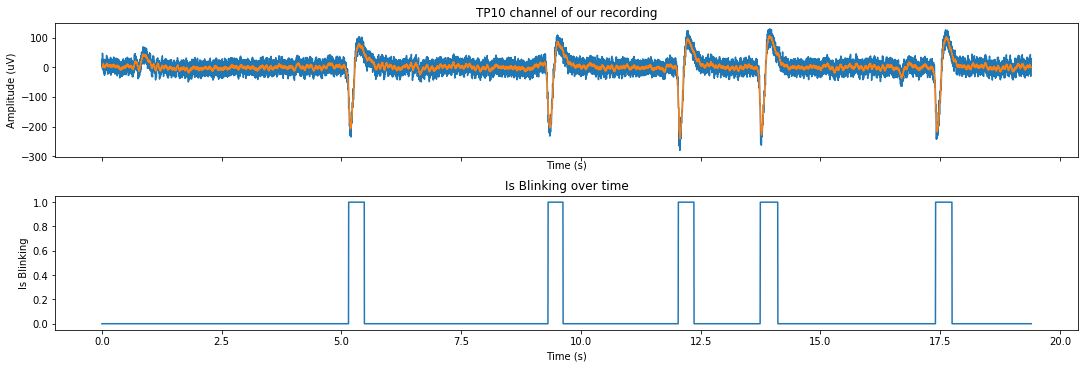

In [95]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data[CHANNEL])
axes[0].plot(eeg_data['timestamps'], filtered_signal)

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], debounced_blink_signal)

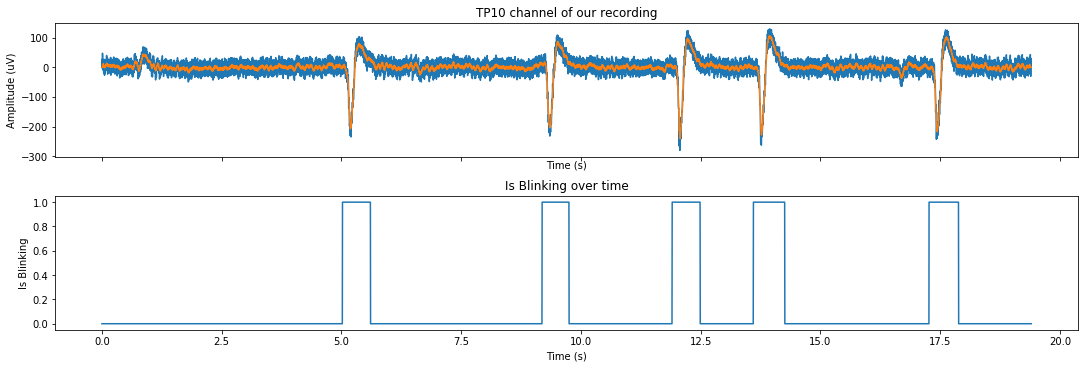

In [96]:
SCALE_FACTOR = 1.8
rising_edges = []
falling_edges = []

for i, is_blinking in enumerate(debounced_blink_signal):
    if is_blinking and not debounced_blink_signal[i-1]:
        # rising edge
        rising_edges.append(i)
    elif not is_blinking and debounced_blink_signal[i-1]:
        # falling edge
        falling_edges.append(i)
        
high_domain = [(rising_edges[i], falling_edges[i]) for i in range(len(rising_edges))]

for domain in high_domain:
    domain_span = domain[1] - domain[0]
    scaled_domain_span = domain_span * SCALE_FACTOR
    indexes_to_set = int((scaled_domain_span - domain_span)/2)
    debounced_blink_signal[domain[0]-indexes_to_set: domain[1]+indexes_to_set] = [True]*(domain[1]+ 2 * indexes_to_set - domain[0])

fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data[CHANNEL])
axes[0].plot(eeg_data['timestamps'], filtered_signal)

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], debounced_blink_signal)

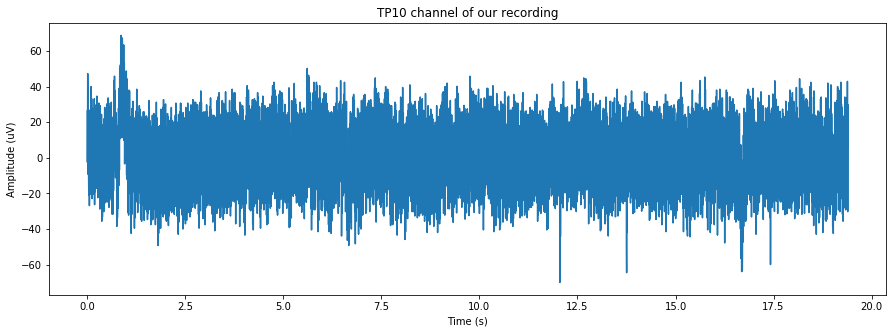

In [97]:
filtered_domain = [index for index, is_blinking in enumerate(debounced_blink_signal) if is_blinking]
for i in filtered_domain:
    eeg_data[CHANNEL][i] -= filtered_signal[i]

# Plot the TP10 channel
plt.figure(figsize=(15,5))
plt.title('TP10 channel of our recording')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.plot(eeg_data['timestamps'], eeg_data[CHANNEL])